In [125]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import kpss, adfuller
from scipy.stats import boxcox


In [63]:
train = pd.DataFrame(pd.read_csv('data/dataset_lab3_train.csv')['humidity'])
test = pd.DataFrame(pd.read_csv('data/dataset_lab3_test.csv')['humidity'])

In [64]:
start_train = datetime(2013, 1, 1)
dates_train = [start_train + timedelta(days=i) for i in range(len(train))]
start_test = start_train + timedelta(days=len(train))
dates_test = [start_test + timedelta(days=i) for i in range(len(test))]

In [65]:
train['date'] = dates_train
test['date'] = dates_test

In [66]:
train.set_index('date', inplace=True)
test.set_index('date', inplace=True)

In [153]:
def three_plot(data):
    fig, axes = plt.subplots(3, 1)
    plt.rcParams.update({'figure.figsize': (10, 10), 'figure.dpi': 90})
    axes[0].plot(data)
    plot_acf(data, ax=axes[1])
    plot_pacf(data, ax=axes[2])
    plt.plot()


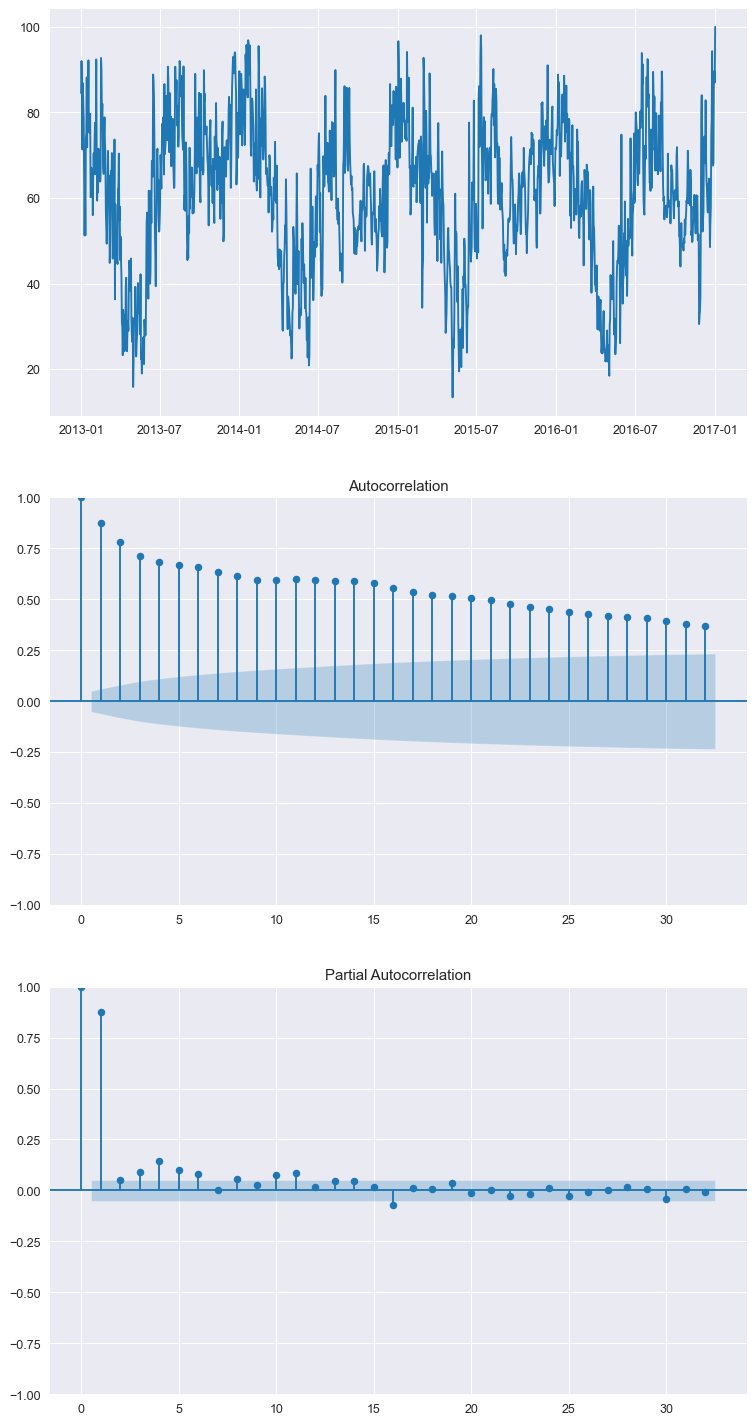

In [109]:
three_plot(train)

In [122]:
def stationary_test(data):
    p_value = adfuller(data)[1]
    is_stat = p_value > 0.05
    print(f'pvalue: {p_value} -> {"stationary" if is_stat else "non stationary"}')
    print(adfuller(data))
    return is_stat

pvalue: 0.0035111827183827837 -> non stationary
(-3.7459626996030972, 0.0035111827183827837, 15, 1446, {'1%': -3.434880391815318, '5%': -2.8635408625359315, '10%': -2.5678352438452814}, 14249.648653349375)


False

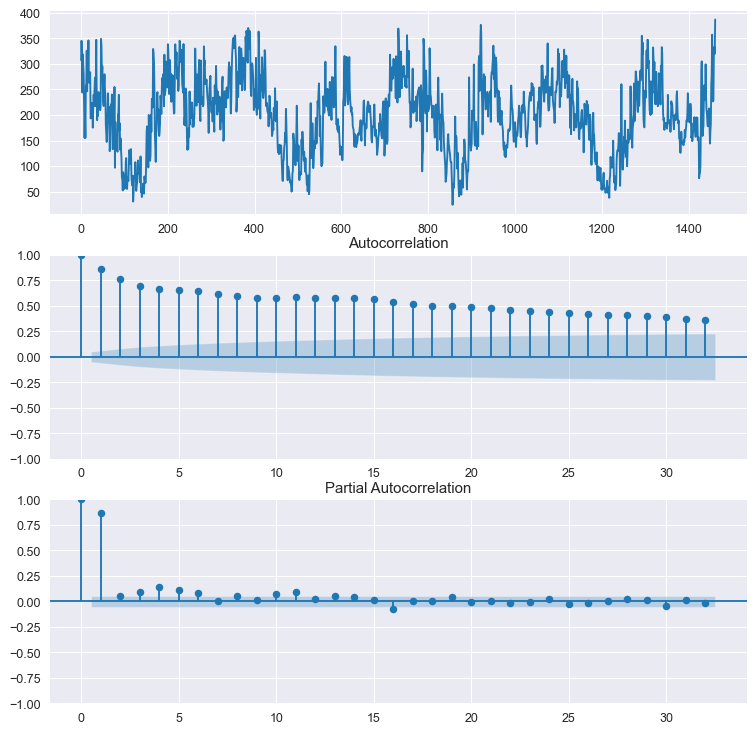

In [156]:
cox, _ = boxcox(train.humidity)
cox = pd.DataFrame(cox)
diff_one = cox
three_plot(diff_one)
stationary_test(diff_one)
# print(f'pvalue: {p_value} -> {"stationary" if p_value < 0.05 else "non stationary"}')